### Intro

We are Ronen lubin (322702275) and Osher Baron (123456789), young computer science students who are passionate about data science.

Since we both like realestate we knew from the beginning of the semester that our project would deal with this topic


### The problem

A lot of people struggle with the question of how much their house is worth
and how much the house will be worth in the future.

We have decided to put an end to this problem for those living in israel


# Obtaininng the data
Our data source for this project is a israeli realestate website called 'Homeless'.
you can go visit the website : https://www.homeless.co.il/sale/

there are tens of thousands of homes for sale in the website and equal amount of rental apartments .

the website does not provide an API for obtaininng the data on the homes,
so we had to build a web scraping tool in order to obtain the information.


### Building the web scraping tool
we used the beautifulsoup python package for this mission.

the code segment below is browsing in the first 160 pages of homes for sale in the website.
for each main page the code extracts the links to the house info,
there are 25 links in each page so in total the method 'get_all_links' return 4000 homes info links.

In [1]:
from bs4 import BeautifulSoup
import requests


# return the apartment id from html element
def get_apartment_id(apartment):
    id_text = apartment['id']
    return id_text.split('_').pop(1)


# constructs new apartment link from the apartments id
def make_link(id):
    return "https://www.homeless.co.il/Sale/viewad," + id + ".aspx"


# return all the apartments links from specific page in the website
def get_apartments_links(page_link="https://www.homeless.co.il/sale/1500"):
    htmt_text = requests.get(page_link).text
    soup = BeautifulSoup(htmt_text, "lxml")
    not_brokerage = soup.find("div", id="display_table")

    apartments = not_brokerage.find_all('tr', type="ad")

    apartments_links = []
    for apartment in apartments:
        id = get_apartment_id(apartment)
        new_link = make_link(id)
        apartments_links.append(new_link)

    return apartments_links


# goes to the specified number page
def go_to_page(page_number):
    return "https://www.homeless.co.il/sale/" + str(page_number)


# return all the apartments links in the website
def get_all_links():
    all_links = []
    for i in range(0, 160):
        links_on_page = get_apartments_links(go_to_page(i))
        all_links = all_links + links_on_page
    return all_links


### Extracting the data from the html content
for each link from the 4000 links we extract the data on the house that the link describes.
the data includes the city where the house is located, the price of the house in the website, the area of the house in sqr m, 
the type of the house, the number of rooms in the house, whether  the house contain bars, whether the house contains furniture, whether there is an elvator in the building, if the is a parking nearby and if air condition is insalled indside the house.


In [294]:
from bs4 import BeautifulSoup
import requests

class Apartment:
    def __init__(self, city, price, area, house_type, rooms, bars, furniture, lift, parking, air_condition):
        self.city = city
        self.price = price
        self.area = area
        self.house_type = house_type
        self.rooms = rooms
        self.bars = bars
        self.furniture = furniture
        self.lift = lift
        self.parking = parking
        self.air_condition = air_condition

    def get_city(self):
        return self.city

    # return the price converted to int
    def get_price(self):
        try:
            price_int = (int(self.price.replace(',', '')))
            return price_int
        except ValueError:
            return 0

    def get_area(self):
        try:
            return int(self.area)
        except ValueError:
            return 0

    def get_house_type(self):
        return self.house_type

    def get_rooms(self):
        return self.rooms

    def get_bars(self):
        return 1 if self.bars else 0

    def get_furniture(self):
        return 1 if self.furniture else 0

    def get_lift(self):
        return 1 if self.lift else 0

    def get_parking(self):
        return self.parking

    def get_air_condition(self):
        return self.air_condition


# return the city where the house is located
def get_city(soup):
    ul_html = soup.find("ul", class_="breadcrumb")
    li_html = ul_html.find_all("a")[1]
    city_html = li_html["href"]
    city = city_html.split("$$")[0].split("=")[1]
    return city


# return the price of the house
def get_price(soup):
    price_html = soup.find("div", class_="price")
    return price_html.text.split().pop(1)


# return the area of the house in squre meters
def get_area(soup):
    balcony_html = soup.find_all("div", style="float:right; width:130px;")[3].text
    return balcony_html.split(':')[1].split('\n')[0]


# return the number of rooms in the house
def get_rooms(soup):
    rooms_html = soup.find("div", class_="right")
    rooms_text = rooms_html.find("h1").string
    return rooms_text.split(',').pop(1).split(' ').pop(1)


# return the house type ( apartment, private home, penthouse .....)
def get_house_type(soup):
    type_html = soup.find("div", class_="right")
    type_text = type_html.find("h1").string
    return type_text.split(',').pop(0)


# return if the house has bars
def has_bars(soup):
    image = soup.find_all("img", class_="itemsAd")[0]["src"]
    if image == "/Images/uncheked.png":
        return False
    elif image == "/Images/checked.png":
        return True


# return if the house has furniture
def has_furniture(soup):
    image = soup.find_all("img", class_="itemsAd")[1]["src"]
    if image == "/Images/uncheked.png":
        return False
    elif image == "/Images/checked.png":
        return True


# return if the house has lift
def has_lift(soup):
    image = soup.find_all("img", class_="itemsAd")[2]["src"]
    if image == "/Images/uncheked.png":
        return False
    elif image == "/Images/checked.png":
        return True


# return the parking in the house
def get_parking(soup):
    parking_html = soup.find_all("div", style="float:right; width:180px;")[1].text
    return parking_html.split(':')[1]


# return the type of air condition
def get_air_condition(soup):
    air_condition = soup.find_all("div", style="float:right; width:180px;")[2].text
    return air_condition.split(':')[1]


# return all the apartments objects
def get_data():
    apartments_links = get_all_links()

    apartments = []
    for apartment_link in apartments_links:
        htmt_text = requests.get(apartment_link).text
        soup = BeautifulSoup(htmt_text, "lxml")

        try:
            city = get_city(soup)
            price = get_price(soup)
            squre_meter = get_area(soup)
            house_type = get_house_type(soup)
            rooms = get_rooms(soup)
            lift = has_lift(soup)
            furniture = has_furniture(soup)
            bars = has_bars(soup)
            parking = get_parking(soup)
            air_condition = get_air_condition(soup)
            new_apartment = Apartment(city, price, squre_meter, house_type, rooms, bars, furniture, lift,
                                      parking, air_condition)

            apartments.append(new_apartment)

        except :
            print("exception in link:" + apartment_link)

    return apartments

### Writing the data to csv file
after we scrapped the info about the homes we sould write it into a csv file, in order to use the informatiom in the future.   
the code down below acomplish this mission:


In [ ]:
import csv


# writes the apartments data to the csv file
def write_to_csv():

    apartments_data = get_data()
    print("finished to gather the data")

    with open('apartments1.csv', "w", newline='', encoding="utf-8") as csvfile:
        csv_writer = csv.writer(csvfile)
        head_line = ['city', 'price', 'area', 'house type', 'rooms', 'bars', 'furniture', 'lift',
                     'parking', 'air condition']
        csv_writer.writerow(head_line)

        for apartment in apartments_data:
            row = []

            row.append(apartment.get_city())
            row.append(apartment.get_price())
            row.append(apartment.get_area())
            row.append(apartment.get_house_type())
            row.append(apartment.get_rooms())
            row.append(apartment.get_bars())
            row.append(apartment.get_furniture())
            row.append(apartment.get_lift())
            row.append(apartment.get_parking())
            row.append(apartment.get_air_condition())

            csv_writer.writerow(row)
            
write_to_csv()

exception in link:https://www.homeless.co.il/Sale/viewad,226391.aspx
exception in link:https://www.homeless.co.il/Sale/viewad,226510.aspx
exception in link:https://www.homeless.co.il/Sale/viewad,212931.aspx


### Run Time
after testing a few runs in the real world we can say confidently that the web scrapper runs in O(N) time complexity (where N is the number of homes).
it took the program approximatly 4600 seconds (1 hour and 17 minutes) to complete the run on 4000 homes, and it took 77 seconds to complete the run on input of 75 homes. a little bit more then 1 second for each apartments on our setup.



# Exploratory data analysis

now after we obtained the data lets export the data set into pandas data frame.
but first we have to import pandas


In [3]:
import pandas as pd

df = pd.read_csv("apartments.csv")
df
df["area"].unique()

array([    90,    157,     57,    160,     96,    100,    678,    112,
          333,    200,    110,    105,    177,    116,    132,    120,
           65,    140,     68,     55,   2211,     70,      0,     80,
          148,     67,    125,     64,    250,     95,    880,    185,
           78,   2000,    145,     56,     88,    144,    175,    111,
          930,     83,     50,    165,    184,     86,    128,     75,
          673,    170,    183,    190,     74,     60,    400,     40,
          375,     77,   3400,    153,    123,     87,     30,     92,
          130,    106,     72,    126,    114,    600,    122, 500000,
          207,    124,     94,    135,     85,    888,    199,    152,
          143,    118,     84,     91,    115,     76,    480,     93,
        24000,   3650,   1000,  15000,    350,    500,    700,   9000,
        23000,   3500,   2100,   8000,    540,    107,    180,   7000,
          147,    240,     98,     79,    172,    220,    155,    108,
      

as you can see there were few exeptions hence we have 3979 rows in the data set and not 4000 rows.


## Cleaning the data
in this section we clear the raw data in order use it later for visiulision and AI.

firstly lets see what values we have in the "house type" coulmn:

In [21]:
df['house type'].unique()

array(['דו משפחתי', 'בית פרטי', 'דופלקס', 'דירה', 'וילה', 'דירת גג',
       'מגרש למגורים', 'דירת גן', 'קוטג', 'מיני פנטהאוז', 'פנטהאוז',
       'משק חקלאי', 'נחלה', 'יחידת דיור', 'חניה', 'טריפלקס',
       'דירת סטודיו', 'לופט', 'קראוון', 'דירה להחלפה'], dtype=object)

lets get rid of the house types that we dont want in our data

In [22]:
types_to_drop = ['משק חקלאי', 'קראוון', 'חניה', 'דירה להחלפה', 'מגרש למגורים', 'נחלה', 'דירה להחלפה', 'לופט', 'יחידת דיור', 'דירת סטודיו', 'טריפלקס', 'מיני פנטהאוז']
df = df[~df['house type'].isin(types_to_drop)]

lets see the values we left with:

In [23]:
df['house type'].unique()

array(['דו משפחתי', 'בית פרטי', 'דופלקס', 'דירה', 'וילה', 'דירת גג',
       'דירת גן', 'קוטג', 'פנטהאוז'], dtype=object)

now after we filterd out the unwanted house types from the data set, we want to drop the homes that are to small or to big.

we determine house to be to small if his area is lesser than 15m^2. house is to big if his area is greater than 650m^2.

we assume that the vast majorty of homes fall in in this catafory.

In [24]:
not_to_small = df["area"] > 15
not_to_big = df["area"] < 650
df = df.where(not_to_small & not_to_big).dropna()

now lets filter homes that are to cheap or to much expensive.

In [25]:
not_to_cheap = df["price"] > 200000
not_to_expensive= df["price"] < 20000000
# homes that are between 200,00 and 20,000,000 shekels
df = df.where(not_to_cheap & not_to_expensive).dropna()

df

,city,price,area,house type,rooms,bars,furniture,lift,parking,air condition
0,רמת גן,2790000.0,90.0,דו משפחתי,4.0,1.0,0.0,0.0,חניה משותפת,בחדרים ובסלון
1,רמת גן,2750000.0,90.0,בית פרטי,4.0,1.0,0.0,0.0,אין,בחדרים ובסלון
2,תל אביב יפו,13000000.0,157.0,דופלקס,6.0,0.0,0.0,1.0,פרטית - לא מקורה,בחדרים
3,תל אביב יפו,1350000.0,57.0,דירה,2.5,1.0,1.0,0.0,ברחוב,בחדרים ובסלון
4,באר שבע,1570000.0,160.0,דירה,4.0,0.0,0.0,1.0,פרטית - מקורה,בחדרים ובסלון
...,...,...,...,...,...,...,...,...,...,...
3972,רחובות,1470000.0,91.0,דירה,3.5,0.0,0.0,0.0,חניה משותפת,בסלון
3974,ראשון לציון,1670000.0,90.0,דירה,4.0,0.0,0.0,1.0,פרטית - מקורה,בחדרים ובסלון
3975,ראשון לציון,2470000.0,340.0,בית פרטי,4.0,0.0,0.0,0.0,פרטית - לא מקורה,בחדרים ובסלון
3977,קרית גת,1850000.0,146.0,פנטהאוז,5.5,0.0,1.0,1.0,פרטית - לא מקורה,מיני מרכזי


as you can see in the data frame above we left with only 3324 homes from the 3979 we began with.
in other words we filterd 16.46% of the original data.

seaborn library does not handle the hebrew language very well,

hence we will replace all the hebew text  with plain english and then run the rest of our code.

In [26]:
# raplaceing 'house type' hebrew with english
list_to_replace = ['דירה', 'דופלקס', 'דו משפחתי', 'בית פרטי', 'קוטג', 'פנטהאוז', 'וילה', 'דירת גן', 'דירת גג']
replce_with = ['apartment', 'duplex', 'dual faimly', 'private house', 'cottage', 'penthouse', 'villa', 'garden apartment', 'roof apartment']
df = df.replace(to_replace =list_to_replace, value =replce_with)

# raplaceing 'parking' hebrew with english
list_to_replace = [' ברחוב', ' פרטית - לא מקורה', ' אין', ' חניה משותפת', ' חניון בתשלום ליד', ' רחבה ציבורית', ' פרטית - מקורה'  ]
replce_with = ['in the street', 'private-outdoor', 'non', 'shared parking', 'parking station nearby', 'public parking', 'private-indoor']
df = df.replace(to_replace =list_to_replace, value = replce_with)

# raplaceing 'air condition' hebrew with english
list_to_replace = [' בחדרים ובסלון', ' בחדרים', 'non', ' מיני מרכזי', ' מיזוג מרכזי', ' בסלון', ' מפוצל']
replce_with = ['in all the rooms', 'in the bedrooms', 'non', 'mini central', 'central', 'in the living room', 'split']
df = df.replace(to_replace =list_to_replace, value = replce_with)


df

,city,price,area,house type,rooms,bars,furniture,lift,parking,air condition
0,רמת גן,2790000.0,90.0,dual faimly,4.0,1.0,0.0,0.0,shared parking,in all the rooms
1,רמת גן,2750000.0,90.0,private house,4.0,1.0,0.0,0.0,non,in all the rooms
2,תל אביב יפו,13000000.0,157.0,duplex,6.0,0.0,0.0,1.0,private-outdoor,in the bedrooms
3,תל אביב יפו,1350000.0,57.0,apartment,2.5,1.0,1.0,0.0,in the street,in all the rooms
4,באר שבע,1570000.0,160.0,apartment,4.0,0.0,0.0,1.0,private-indoor,in all the rooms
...,...,...,...,...,...,...,...,...,...,...
3972,רחובות,1470000.0,91.0,apartment,3.5,0.0,0.0,0.0,shared parking,in the living room
3974,ראשון לציון,1670000.0,90.0,apartment,4.0,0.0,0.0,1.0,private-indoor,in all the rooms
3975,ראשון לציון,2470000.0,340.0,private house,4.0,0.0,0.0,0.0,private-outdoor,in all the rooms
3977,קרית גת,1850000.0,146.0,penthouse,5.5,0.0,1.0,1.0,private-outdoor,mini central


## Visiulise the data
lets plot few graphs in order to visiulise the data set.

firts we have histogram of the prices of all the homes in the data frame.


Text(0, 0.5, 'Frequency')

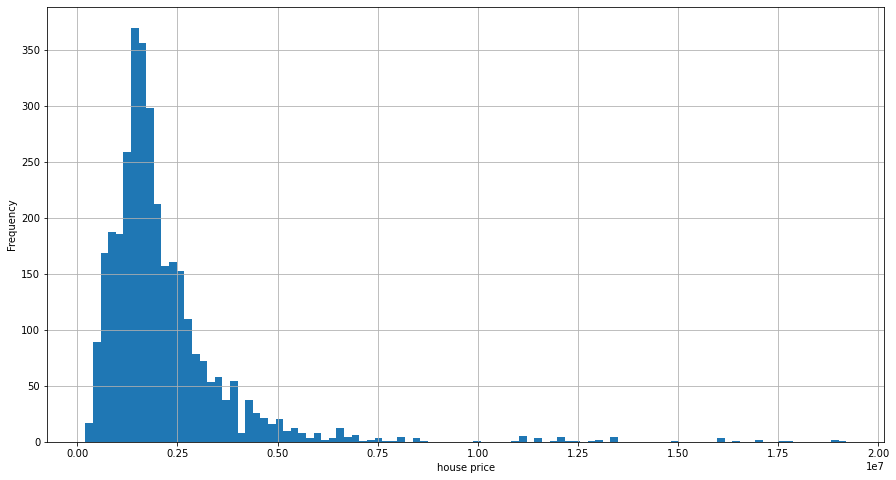

In [27]:
import matplotlib.pyplot as plt; 
import numpy as np
import seaborn as sns

plt.figure(figsize=(15,8))
df.price.hist(bins=100)
plt.xlabel('house price')
plt.ylabel('Frequency')

as you can see the mean house price is 1,800,000~  shekels

now, lets plot the histogram of home size:

<AxesSubplot:xlabel='area', ylabel='Density'>

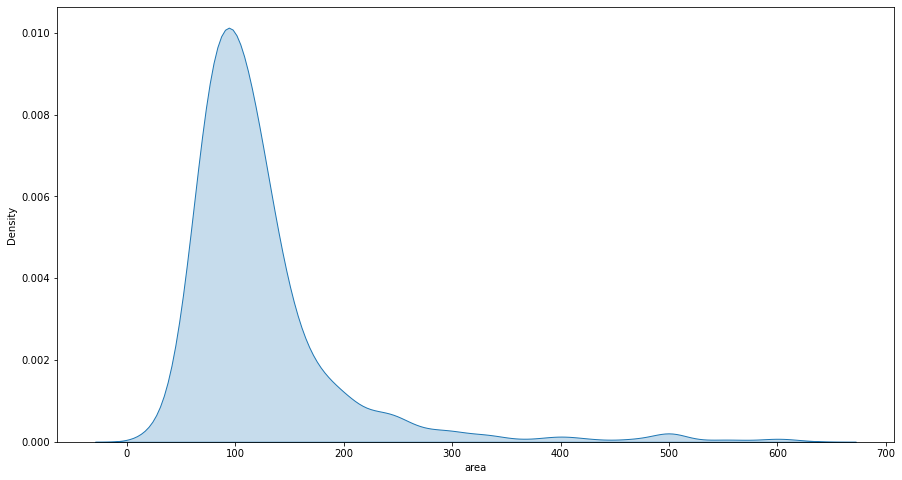

In [28]:
plt.figure(figsize=(15,8))
sns.kdeplot(df.area,  shade=True)

as you can see the mean house size is 115~ squre meter

lets draw the correlation between size and pirce

<AxesSubplot:xlabel='area', ylabel='price'>

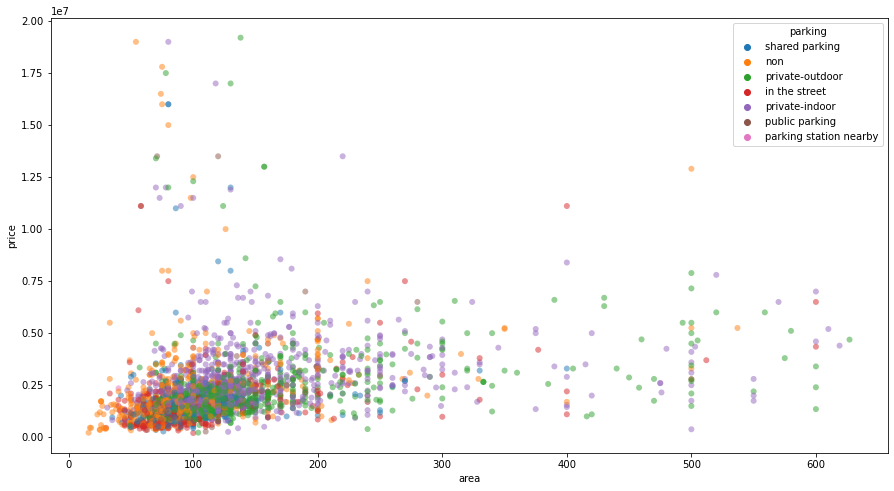

In [29]:
plt.figure(figsize=(15,8))
sns.scatterplot(x="area", y="price",
                hue="parking", alpha=0.5,
                sizes=(1, 8), linewidth=0,
                data=df)

how does size correlate with rooms number?

<AxesSubplot:xlabel='area', ylabel='rooms'>

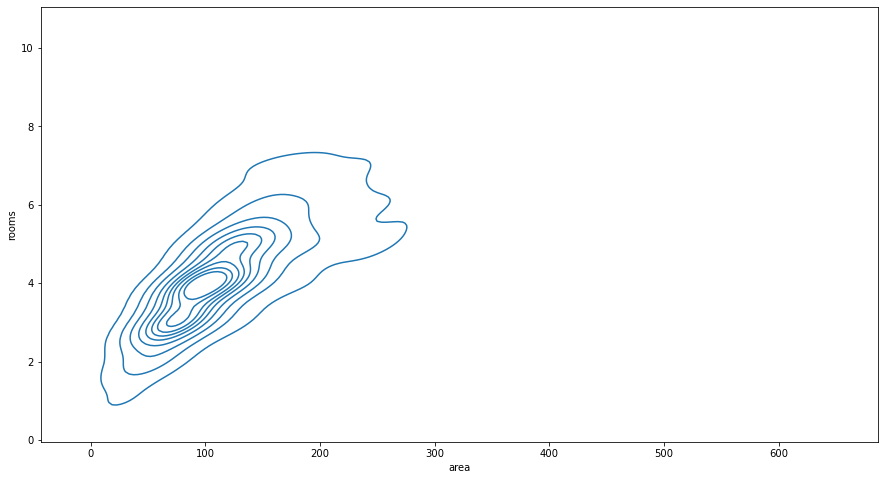

In [30]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=df,  x="area",  y="rooms", thresh=.1)

lets look on the connection between house size the number of rooms in the hous and his price:

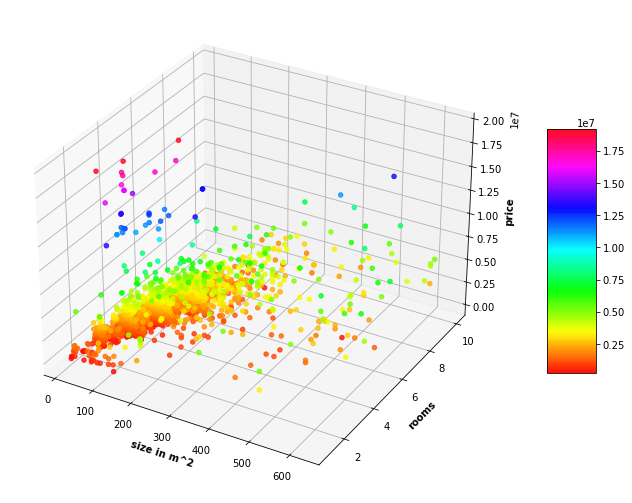

In [31]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (18, 9))
ax = plt.axes(projection ="3d")

my_cmap = plt.get_cmap('hsv')

x = df["area"]
y = df["rooms"]
z = df["price"]
sctt = ax.scatter3D(x, y, z, cmap = my_cmap, c = z ,alpha = 0.8 )


ax.set_xlabel('size in m^2', fontweight ='bold')
ax.set_ylabel('rooms', fontweight ='bold')
ax.set_zlabel('price', fontweight ='bold')

fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

lest draw a pie chart that describes the disterbution of different house types

([<matplotlib.patches.Wedge at 0x187450f2820>,
 [Text(-0.6920908267621086, 0.8549913961624065, 'apartment'),
  Text(-0.12758747133308304, -1.092575597914776, 'cottage'),
  Text(0.09966823442933237, -1.0954753502684302, 'dual faimly'),
  Text(0.3266425074898743, -1.050383107394977, 'duplex'),
  Text(0.6065815246491463, -0.9176376485052895, 'garden apartment'),
  Text(0.8343498949880356, -0.716840465329249, 'penthouse'),
  Text(0.9998478908464912, -0.4585893535286479, 'private house'),
  Text(1.0817505206841227, -0.1995389961877868, 'roof apartment'),
  Text(1.097924940724571, -0.06753387694296384, 'villa')],
 [Text(-0.37750408732478646, 0.46635894336131256, '71.7%'),
  Text(-0.06959316618168165, -0.5959503261353323, '3.0%'),
  Text(0.05436449150690856, -0.5975320092373255, '3.6%'),
  Text(0.17816864044902234, -0.5729362403972601, '3.1%'),
  Text(0.3308626498086252, -0.5005296264574306, '5.9%'),
  Text(0.4550999427207466, -0.39100389017959036, '2.9%'),
  Text(0.5453715768253588, -0.25013

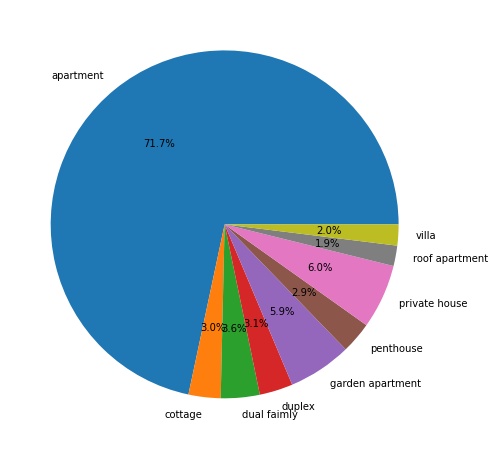

In [32]:
data = df.groupby("house type").count()
labels  = data.index.values.tolist()
data_list =  data['city'].tolist()


plt.figure(figsize=(15,8))
plt.pie(data_list, labels = labels, autopct='%.1f%%')

as you can see the seaborn library does not handle the hebrew language very well,
hence we will replace all the hebew text in the 'house type' coulmn with plain english and then run the code again.

now it will be nice to see whether having elevator in your apartment affect the price of the apartment.

but first we have to sort out all the homes that qualified as apartmens

<AxesSubplot:xlabel='house type', ylabel='price'>

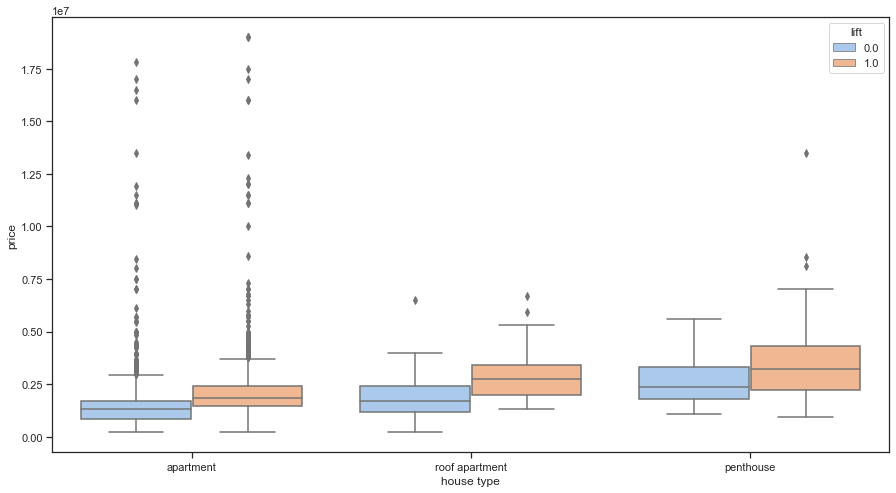

In [33]:
# filter where lift does matter  
apartment = df["house type"] == "apartment"
roof_apartment = df["house type"] == "roof apartment"
penthouse = df["house type"] == "penthouse"
apartments = df.where(apartment | roof_apartment | penthouse ).dropna()

# drawing the plot
sns.set_theme(style="ticks", palette="pastel")
plt.figure(figsize=(15,8))
sns.boxplot(x="house type", y="price",  hue="lift", data=apartments)

its clear from the plot that exsiting of an elevator in the building corolate positivly with homes price 

now lets look what about furniture:

<AxesSubplot:xlabel='house type', ylabel='price'>

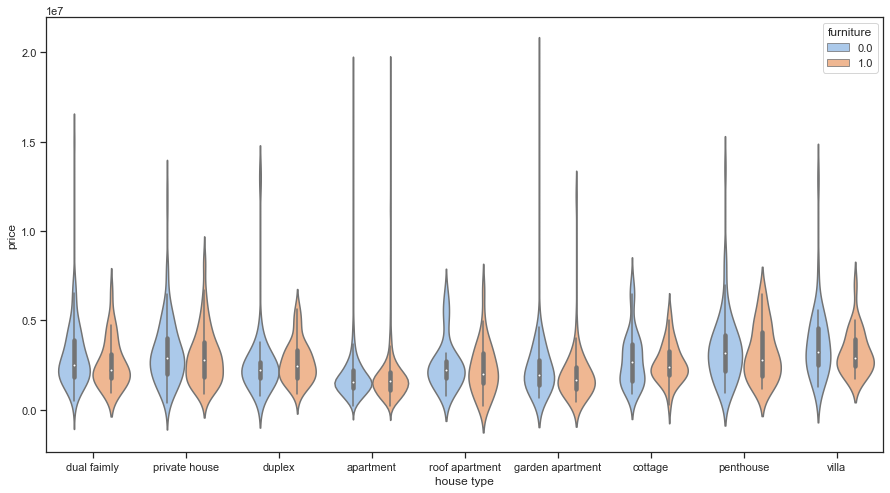

In [34]:
sns.set_theme(style="ticks", palette="pastel")
plt.figure(figsize=(15,8))
sns.violinplot(x="house type", y="price",  hue="furniture", data=df)

there is no clear visible correlation between absence of furniture in the house and his price.

lastly, what about having bars in the house?

<AxesSubplot:xlabel='house type', ylabel='price'>

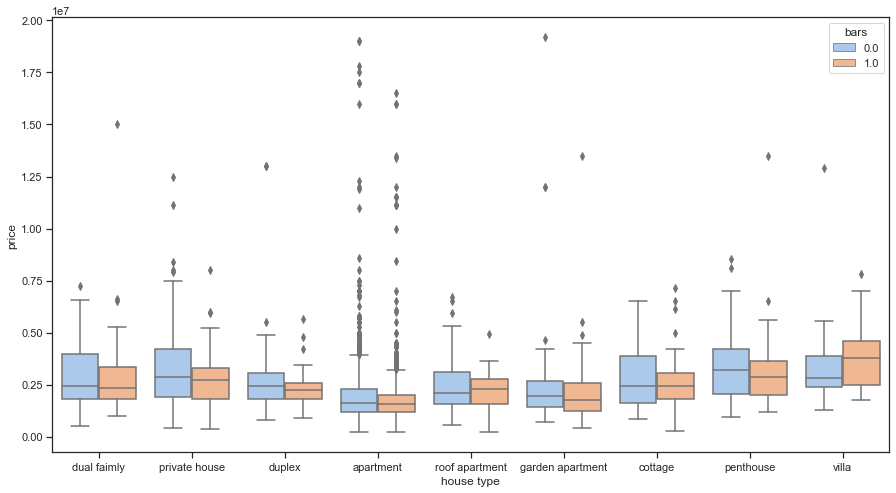

In [35]:
sns.set_theme(style="ticks", palette="pastel")
plt.figure(figsize=(15,8))
sns.boxplot(x="house type", y="price",  hue="bars", data=df)

again, no clear effect on the house price

## Finding Correlations
lets found the correlations of the numeric values in our data set:

In [36]:
corr = df.corr()
  
corr

,price,area,rooms,bars,furniture,lift
price,1.000000,0.317219,0.249973,-0.061147,-0.040416,0.083431
area,0.317219,1.000000,0.655663,-0.065323,0.002896,-0.091414
rooms,0.249973,0.655663,1.000000,-0.030916,0.038329,-0.024535
bars,-0.061147,-0.065323,-0.030916,1.000000,0.105763,-0.064660
furniture,-0.040416,0.002896,0.038329,0.105763,1.000000,0.019507
lift,0.083431,-0.091414,-0.024535,-0.064660,0.019507,1.000000


lets plot it:

<AxesSubplot:>

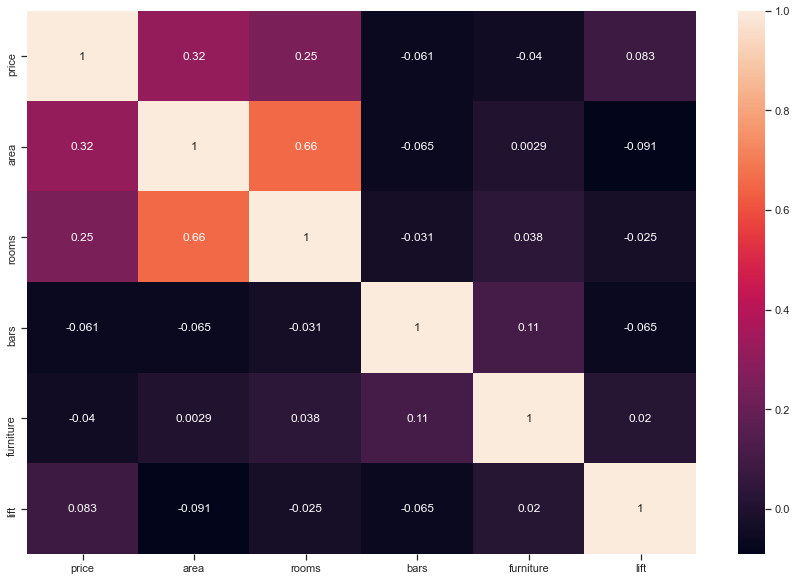

In [18]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True)

as you can see the highest correlation between price and other numeric parmater is area. but still correlation of 0.32 is consiederd quite low, so how we explain this?

as we already said we only took into calculation the numeric parmaters, but 'city' is not numeric and we know that it is among the crucial parmaters when determing house price.

###  Back to visiulistion

lets look on the 10 most frequent cities to apear in our data set

In [37]:
ten_most_popular_cities = df['city'].value_counts().index.tolist()[0:10]
ten_most_popular_cities

['ירושלים',
 'תל אביב יפו',
 'חולון',
 'חיפה',
 'ראשון לציון',
 'באר שבע',
 'אשקלון',
 'נתניה',
 'רמת גן',
 'בת ים']

now lets build new data frame consists only of the most popular cities

In [38]:
df_popular_cities = df[df['city'].isin(ten_most_popular_cities)]
df_popular_cities 

,city,price,area,house type,rooms,bars,furniture,lift,parking,air condition
0,רמת גן,2790000.0,90.0,dual faimly,4.0,1.0,0.0,0.0,shared parking,in all the rooms
1,רמת גן,2750000.0,90.0,private house,4.0,1.0,0.0,0.0,non,in all the rooms
2,תל אביב יפו,13000000.0,157.0,duplex,6.0,0.0,0.0,1.0,private-outdoor,in the bedrooms
3,תל אביב יפו,1350000.0,57.0,apartment,2.5,1.0,1.0,0.0,in the street,in all the rooms
4,באר שבע,1570000.0,160.0,apartment,4.0,0.0,0.0,1.0,private-indoor,in all the rooms
...,...,...,...,...,...,...,...,...,...,...
3967,בת ים,2450000.0,100.0,apartment,4.0,1.0,0.0,0.0,non,central
3970,תל אביב יפו,6500000.0,170.0,apartment,5.0,1.0,1.0,1.0,private-outdoor,in all the rooms
3971,באר שבע,510000.0,72.0,apartment,3.0,0.0,1.0,1.0,shared parking,in all the rooms
3974,ראשון לציון,1670000.0,90.0,apartment,4.0,0.0,0.0,1.0,private-indoor,in all the rooms


lets see what is the average home price in each city

Text(0.5, 1.0, 'average price by city')

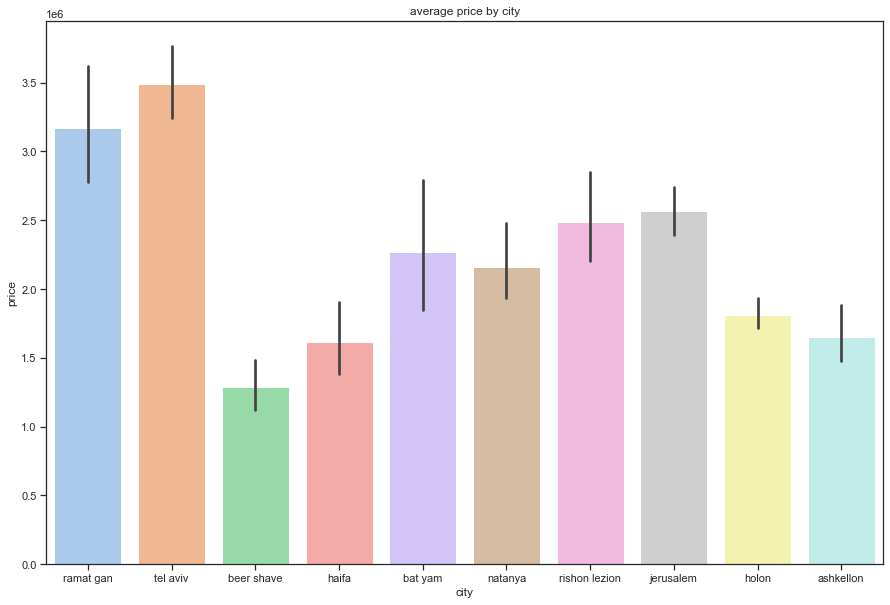

In [39]:
# translate the citites to english because seaborn doesnt handle hebrew well
cities_hebrew = ['רמת גן', 'תל אביב יפו', 'באר שבע', 'חיפה', 'בת ים', 'נתניה', 'ראשון לציון', 'ירושלים', 'חולון', 'אשקלון']
cities_english = ['ramat gan', 'tel aviv', 'beer shave', 'haifa', 'bat yam', 'natanya', 'rishon lezion', 'jerusalem', 'holon', 'ashkellon']
df_popular_cities = df_popular_cities.replace(to_replace =cities_hebrew, value = cities_english)

plt.figure(figsize=(15, 10))
sns.barplot(x = 'city', y = 'price' , data = df_popular_cities, edgecolor = 'w').set_title('average price by city')

we can see that the average price of house in the mose expensive city tel aviv the is almost 3.5 milion shekels.
while the price in the cheapest city in our list (haifa) is around 1.3 milion shekels.

we know that parking is scarce in tel aviv, can we see it in our data?

Text(0, 0.5, 'Relative frequency')

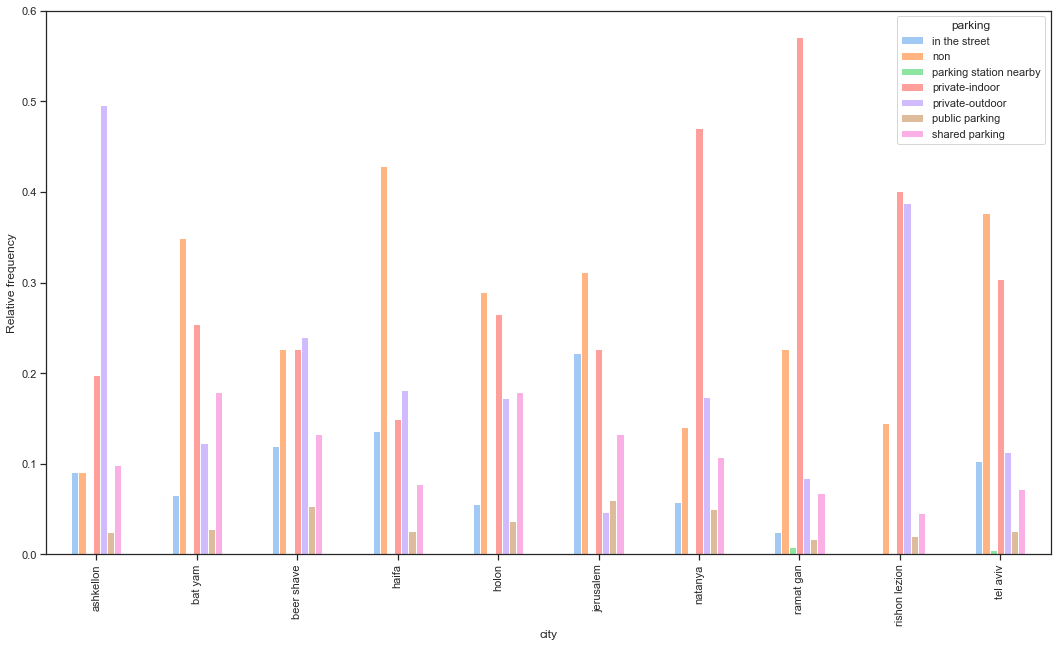

In [40]:
cross_tab =  pd.crosstab(df_popular_cities["city"], df_popular_cities["parking"], normalize ='index' )

cross_tab.plot(kind = 'bar', figsize=(18, 10))
plt.ylabel("Relative frequency")

40% of house for sale in tel aviv does not have parking, but the highest precentage for homes without parking found suprisly in haifa the cheapest city in our list.

now, lets look how air condition effects the home price:

<AxesSubplot:xlabel='city', ylabel='price'>

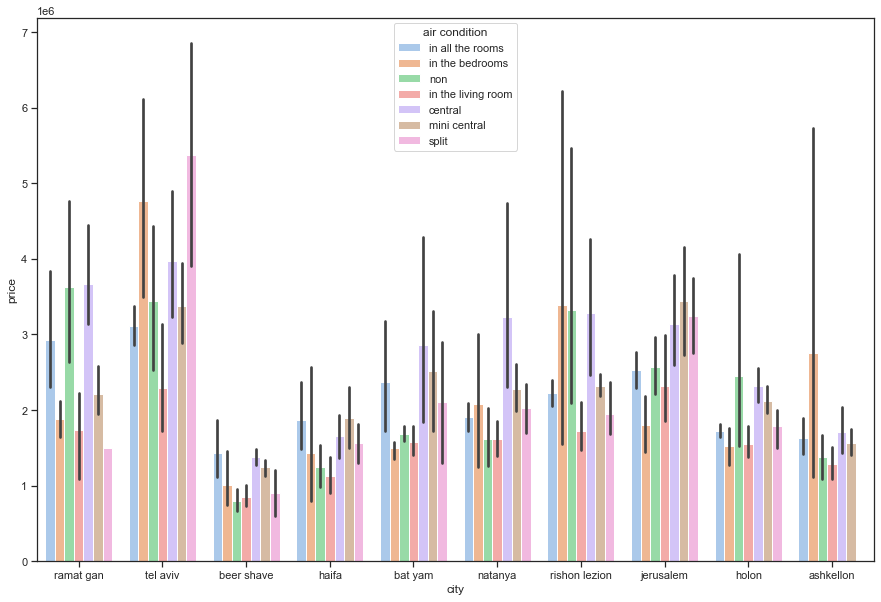

In [41]:
plt.figure(figsize=(15, 10))
sns.barplot(x = 'city', y = 'price', hue ='air condition', data = df_popular_cities, edgecolor = 'w')

lastly, lets look on disterbution of house types in different cities by price

C:\Users\ronen\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 21.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\ronen\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\ronen\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 20.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\ronen\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 13.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\ronen\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 13.2% of the points 

[Text(0, 0.5, '')]

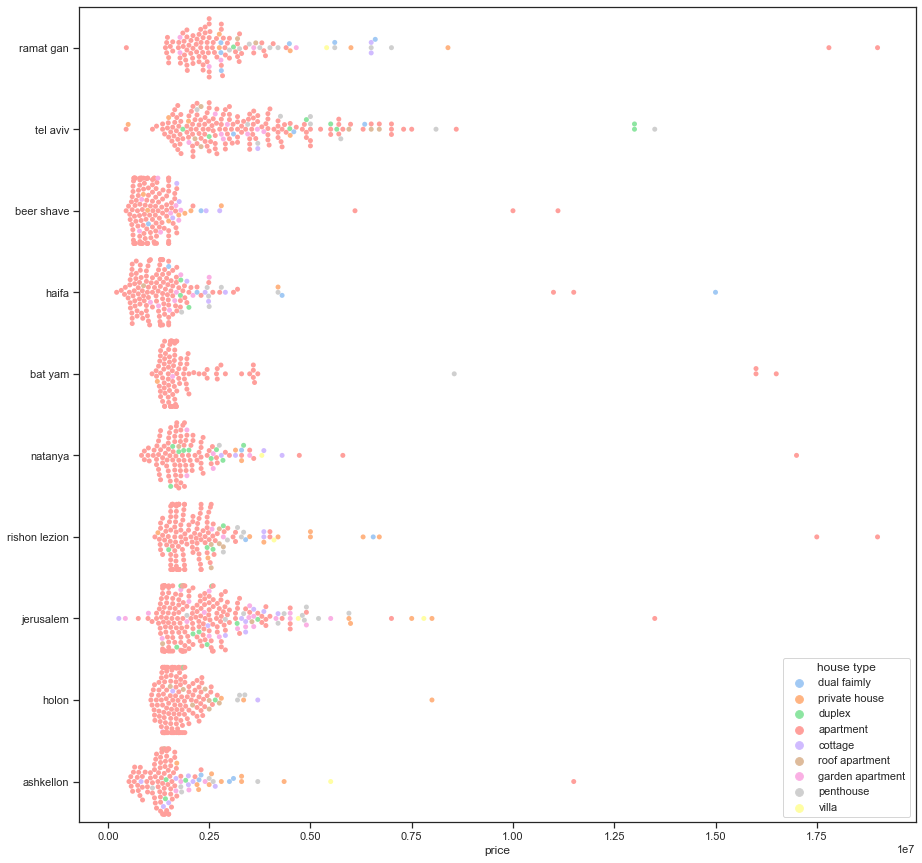

In [42]:
plt.figure(figsize=(15, 15))

ax = sns.swarmplot(data=df_popular_cities, x="price", y="city", hue="house type")
ax.set(ylabel="")